In [3]:
import requests
import hashlib
import time
import csv
import os
import pandas as pd
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

/Users/xichen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
%pip install community

# 1. Marvel Character Data Collecttion

Import Marvel public key and private key

In [4]:
public_key = "757798fa5b2e4dfeeddc8bb6bfe075db"
private_key = "5c353f13586e7d17ef5ee8a283bc3c722bb7b5fc"

base_url = "https://gateway.marvel.com/v1/public/characters"

# timestamp
timestamp = str(time.time())
hash_value = hashlib.md5(f"{timestamp}{private_key}{public_key}".encode()).hexdigest()

## 1.1. Request for the total num of characters

In [5]:
params = {
    "apikey": public_key,
    "ts": timestamp,
    "hash": hash_value,
    "limit": 1 
}

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    total_characters = data["data"]["total"]
    print(f"Total num of characters in Marvel Comics : {total_characters}")
else:
    print(f"Request Failed: Status code {response.status_code}, Info: {response.text}")

Total num of characters in Marvel Comics : 1564


## 1.2. Request for the detailed info of each characters

In [ ]:
output_folder = "Data/Marvel Character/Comics"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "marvel_characters.csv")

# Initialize CSV file
with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["id", "name", "description"])
    writer.writeheader()

    limit = 100  # NUmber of characters to fetch per request
    offset = 0 
    total = None

    while True:
        params = {
            "apikey": public_key,
            "ts": timestamp,
            "hash": hash_value,
            "limit": limit,
            "offset": offset
        }

        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            total = data["data"]["total"] if total is None else total
            results = data["data"]["results"]

            for character in results:
                writer.writerow({
                    "id": character["id"],
                    "name": character["name"],
                    "description": character["description"]
                })

            print(f"Processed {offset + len(results)}/{total} characters...")

            offset += limit
            if offset >= total:
                break
        else:
            print(f"Request Failed: Status code {response.status_code}, Info: {response.text}")
            break

print(f"Marvel Characters data are saved to : {output_file}")

## 1.3. Request for total num of comics

In [207]:
public_key = "757798fa5b2e4dfeeddc8bb6bfe075db" 
private_key = "5c353f13586e7d17ef5ee8a283bc3c722bb7b5fc"
base_url = "https://gateway.marvel.com/v1/public/comics"

timestamp = str(time.time())
hash_value = hashlib.md5(f"{timestamp}{private_key}{public_key}".encode()).hexdigest()
params = {
    "apikey": public_key,
    "ts": timestamp,
    "hash": hash_value,
    "limit": 1 
}

# Send GET request
response = requests.get(base_url, params=params)

# Process the response
if response.status_code == 200:
    data = response.json()
    total_comics = data["data"]["total"]
    print(f"Total num of comics in Marvel Comics: {total_comics}")
else:
    print(f"Request Failed: Status code {response.status_code}, Info: {response.text}")

Total num of comics in Marvel Comics: 63132


## 1.4. Request for the info of collaboration between characters

In [ ]:
# Marvel API keys
public_key = "757798fa5b2e4dfeeddc8bb6bfe075db"
private_key = "5c353f13586e7d17ef5ee8a283bc3c722bb7b5fc"
base_url = "https://gateway.marvel.com/v1/public/comics"

# Generate hash and timestamp
def generate_params(offset):
    timestamp = str(time.time())
    hash_value = hashlib.md5(f"{timestamp}{private_key}{public_key}".encode()).hexdigest()
    return {
        "apikey": public_key,
        "ts": timestamp,
        "hash": hash_value,
        "limit": 25,
        "offset": offset,
    }

# File paths
progress_file = "progress.txt"
output_file = "Data/Marvel Character/Original Data/character_collaboration_matrix5.csv"

# Load progress
try:
    with open(progress_file, "r") as f:
        offset = int(f.read().strip())
    print(f"Resuming from offset: {offset}")
except FileNotFoundError:
    offset = 0
    print("Starting from the beginning.")

# Total comics count
total_comics = 62951

# Initialize data structures
character_set = set()
collaboration_matrix = defaultdict(int)

# Main loop
while offset < total_comics:
    print(f"Fetching comics {offset} to {offset + 25}...")
    params = generate_params(offset)

    # Retry mechanism
    max_retries = 5
    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=15)
            if response.status_code == 200:
                break
        except (requests.ConnectionError, requests.ReadTimeout) as e:
            print(f"Attempt {attempt + 1} failed: {e}. Retrying...")
            time.sleep(2)
    else:
        print("Max retries reached. Exiting.")
        break

    if response.status_code != 200:
        print(f"Request failed: {response.text}")
        break

    data = response.json()
    comics = data["data"]["results"]

    # Process each comic
    for comic in comics:
        characters = [char["name"] for char in comic["characters"]["items"]]
        print(f"Comic: {comic['title']} | Characters: {', '.join(characters)}")

        # Update character set and collaboration matrix
        character_set.update(characters)
        for pair in combinations(characters, 2):
            collaboration_matrix[pair] += 1

    # Update offset
    offset += 25
    with open(progress_file, "w") as f:
        f.write(str(offset))
    print(f"Progress saved at offset: {offset}")

    # Save intermediate results to file
    character_list = sorted(character_set)
    matrix = pd.DataFrame(0, index=character_list, columns=character_list)

    for (char_a, char_b), count in collaboration_matrix.items():
        matrix.loc[char_a, char_b] += count
        matrix.loc[char_b, char_a] += count

    matrix["Total Collaborations"] = matrix.sum(axis=1)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    matrix.to_csv(output_file)
    print(f"Collaboration matrix saved to '{output_file}'.")

    # Delay to avoid rate limits
    time.sleep(1)

print("Data fetching and processing complete.")

In [ ]:
file1_path = "updated_collaboration_matrix_sorted3.csv"
collaboration_matrix = pd.read_csv(file1_path, index_col=0)
if "Total Collaborations" in collaboration_matrix.columns:
    collaboration_matrix = collaboration_matrix.iloc[:, :-1] 

file2_path = "Data/Marvel Character/Original Data/character_collaboration_matrix5.csv"
new_data = pd.read_csv(file2_path, index_col=0)
if "Total Collaborations" in new_data.columns:
    new_data = new_data.iloc[:, :-1]

all_characters = list(set(collaboration_matrix.index).union(set(new_data.index)))

new_matrix = pd.DataFrame(
    0, index=all_characters, columns=all_characters
)

for character in collaboration_matrix.index:
    for col in collaboration_matrix.columns:
        new_matrix.loc[character, col] += collaboration_matrix.loc[character, col]

for character in new_data.index:
    for col in new_data.columns:
        new_matrix.loc[character, col] += new_data.loc[character, col]

new_matrix["Total Collaborations"] = new_matrix.sum(axis=1)

new_matrix = new_matrix.sort_index(axis=0).sort_index(axis=1)

columns = [col for col in new_matrix.columns if col != "Total Collaborations"] + ["Total Collaborations"]
new_matrix = new_matrix[columns]

output_path = "Data/Marvel Character/marvel_character_collaboration.csv"
new_matrix.to_csv(output_path)

print(f"Combined data is saved to：{output_path}")

In [ ]:
file_path = "Data/Marvel Character/marvel_character_collaboration.csv"
data = pd.read_csv(file_path, index_col=0) 

def extract_base_name(name):
    return name.split(" (")[0].strip()

base_names = [extract_base_name(name) for name in data.index]
data.index = base_names
data.columns = [extract_base_name(name) for name in data.columns]

data = data.groupby(data.index).sum()
data = data.groupby(data.columns, axis=1).sum()

data["Total Collaborations"] = data.sum(axis=1)

data = data[[col for col in data.columns if col != "Total Collaborations"] + ["Total Collaborations"]]
output_path = "Data/Marvel Character/marvel_character_collaboration2.csv"
data.to_csv(output_path)

print(f"Processed data saved to {output_path}")

In [ ]:
# Marvel API credentials
PUBLIC_KEY = "757798fa5b2e4dfeeddc8bb6bfe075db"
PRIVATE_KEY = "5c353f13586e7d17ef5ee8a283bc3c722bb7b5fc"
BASE_URL = "https://gateway.marvel.com/v1/public/characters"

# Generate hash for API requests
def generate_hash(ts, private_key, public_key):
    return hashlib.md5(f"{ts}{private_key}{public_key}".encode()).hexdigest()

# Fetch all characters and filter teams
def fetch_team_characters():
    ts = str(time.time())
    hash_key = generate_hash(ts, PRIVATE_KEY, PUBLIC_KEY)
    offset = 0
    limit = 100  # Max limit per request
    teams = []
    team_keywords = [
        "team", "group", "squad", "avengers", "x-men", "guardians", "league", 
        "brotherhood", "illuminati", "order", "society", "force", "mutants"
    ]

    while True:
        params = {
            "apikey": PUBLIC_KEY,
            "ts": ts,
            "hash": hash_key,
            "limit": limit,
            "offset": offset
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            results = data["data"]["results"]
            for char in results:
                name = char.get("name", "")
                description = char.get("description", "").lower()
                if any(keyword in description for keyword in team_keywords):
                    teams.append({"name": name, "type": "Team"})
            # Check if all characters are fetched
            if len(results) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching data: {response.status_code}")
            break

    return pd.DataFrame(teams)

# Fetch and save team characters
team_characters_df = fetch_team_characters()
team_characters_df.to_csv("marvel_team_characters.csv", index=False)
print("Team characters saved to marvel_team_characters.csv")

In [ ]:
# Marvel API credentials
PUBLIC_KEY = "757798fa5b2e4dfeeddc8bb6bfe075db"
PRIVATE_KEY = "5c353f13586e7d17ef5ee8a283bc3c722bb7b5fc"
BASE_URL = "https://gateway.marvel.com/v1/public/characters"

# Generate hash for API requests
def generate_hash(ts, private_key, public_key):
    return hashlib.md5(f"{ts}{private_key}{public_key}".encode()).hexdigest()

# Fetch Avengers members
def fetch_team_members(team_name="Avengers"):
    ts = str(time.time())
    hash_key = generate_hash(ts, PRIVATE_KEY, PUBLIC_KEY)
    offset = 0
    limit = 100  # Max limit per request
    team_members = []

    while True:
        params = {
            "apikey": PUBLIC_KEY,
            "ts": ts,
            "hash": hash_key,
            "nameStartsWith": team_name,
            "limit": limit,
            "offset": offset
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            results = data["data"]["results"]
            for char in results:
                team_members.append({
                    "name": char.get("name", ""),
                    "description": char.get("description", "")
                })
            # Check if all characters are fetched
            if len(results) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching data: {response.status_code}")
            break

    return pd.DataFrame(team_members)

# Fetch and save Avengers members
avengers_df = fetch_team_members("Avengers")
avengers_df.to_csv("avengers_members.csv", index=False)
print("Avengers members saved to avengers_members.csv")

Delete Top3 most popular team

In [ ]:
file_path = "Data/Marvel Character/marvel_character_collaboration.csv" 
data = pd.read_csv(file_path, index_col=0)

popular_groups = ["X-Men", "Avengers", "Fantastic Four"]

filtered_data = data.drop(index=popular_groups, columns=popular_groups, errors='ignore')

if 'Total' in filtered_data.columns:
    filtered_data['Total'] = filtered_data.sum(axis=1)

output_path = "Data/Marvel Character/marvel_character_collaboration_filtered.csv"
filtered_data.to_csv(output_path)

print(f"Filtered data saved to {output_path}")

In [58]:
input_file = "Data/Marvel Character/marvel_character_collaboration_filtered.csv"

data = pd.read_csv(input_file, index_col=0)
data = data.iloc[:, :-1]

output_file = "Data/Marvel Character/marvel_character_collaboration_filtered.csv"
data.to_csv(output_file)

## 1.5. Generate Edge-List 

In [206]:
input_file = "Data/Marvel Character/marvel_character_collaboration_filtered.csv"
data = pd.read_csv(input_file, index_col=0)

edge_list = []

for i, row in enumerate(data.index):
    for j, col in enumerate(data.columns[i + 1:]):
        weight = data.iloc[i, i + 1 + j]
        if weight > 0:
            edge_list.append([row, col, weight])

edge_df = pd.DataFrame(edge_list, columns=["Node", "Edge", "Weight"])

output_file = "Data/Marvel Character/marvel_character_edge_list.csv"
edge_df.to_csv(output_file, index=False)

print(f"Edge list has been saved to {output_file}")

Edge list has been saved to Data/Marvel Character/marvel_character_edge_list.csv


# 2. Analysis for the Marvel Collaboration Network

## 2.1. Basic Network Statistics

Number of nodes: 1086
Number of edges: 37800
Average degree: 69.61
Average clustering coefficient: 0.63
Network diameter: Graph is not connected


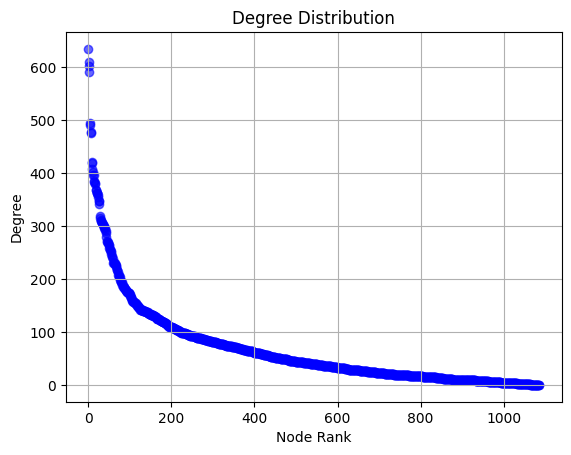

In [139]:
# Step 1: Load data and create the graph
edge_list_file = "Data/Marvel Character/marvel_character_edge_list.csv"
edges = pd.read_csv(edge_list_file)
G = nx.from_pandas_edgelist(edges, source="Node", target="Edge")

# Step 2: Compute basic statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes
average_clustering = nx.average_clustering(G)
network_diameter = nx.diameter(G) if nx.is_connected(G) else "Graph is not connected"

# Print results
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {average_degree:.2f}")
print(f"Average clustering coefficient: {average_clustering:.2f}")
print(f"Network diameter: {network_diameter}")

# Step 3: Visualize degree distribution as a scatter plot
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.scatter(range(len(degree_sequence)), degree_sequence, color="blue", alpha=0.6)
plt.title("Degree Distribution")
plt.xlabel("Node Rank")
plt.ylabel("Degree")
plt.grid(True)
plt.show()

## 2.2. Community Detection

Generate Edge-table and Node-table for futher use

In [203]:
# Reload the edge list data
edge_list_file = "Data/Marvel Character/marvel_character_edge_list.csv"
edges = pd.read_csv(edge_list_file)

# Generate Nodes Table
nodes = pd.DataFrame({
    "ID": pd.concat([edges["Node"], edges["Edge"]]).unique(),
    "Label": pd.concat([edges["Node"], edges["Edge"]]).unique()
})

nodes["Community"] = "Unknown"  # Replace with real data later

edges_table = edges.rename(columns={"Node": "Source", "Edge": "Target", "Weight": "Weight"})

nodes_table_file = "Data/Marvel Character/Gephi Data/marvel_character_nodes_table.csv"
edges_table_file = "Data/Marvel Character/Gephi Data/marvel_character_edges_table.csv"

nodes.to_csv(nodes_table_file, index=False)
edges_table.to_csv(edges_table_file, index=False)

(nodes_table_file, edges_table_file)

('Data/Marvel Character/Gephi Data/marvel_character_nodes_table.csv',
 'Data/Marvel Character/Gephi Data/marvel_character_edges_table.csv')

Add community into Nodes-table

In [205]:
edge_list_file = "Data/Marvel Character/marvel_character_edge_list.csv"
edges = pd.read_csv(edge_list_file)

G = nx.from_pandas_edgelist(edges, source="Node", target="Edge", edge_attr="Weight")

partition = community_louvain.best_partition(G)
nodes_table_file = "Data/Marvel Character/Gephi Data/marvel_character_nodes_table.csv"
nodes = pd.read_csv(nodes_table_file)

nodes["Community"] = nodes["ID"].map(partition)

nodes.to_csv(nodes_table_file, index=False)

print(f"Community information has been added to the nodes table and saved to {nodes_table_file}")

Community information has been added to the nodes table and saved to Data/Marvel Character/Gephi Data/marvel_character_nodes_table.csv


## 2.3. Centrality Metrics Calculation

In [94]:
edge_list_file = "Data/Marvel Character/marvel_character_edge_list.csv"
edges = pd.read_csv(edge_list_file)
G = nx.from_pandas_edgelist(edges, source="Node", target="Edge", edge_attr="Weight")

In [123]:
# Step 1: Calculate centrality metrics
weighted_degree_centrality = dict(G.degree(weight='Weight'))
betweenness_centrality = nx.betweenness_centrality(G, weight='Weight')
eigenvector_centrality = nx.eigenvector_centrality(G, weight='Weight')
pagerank = nx.pagerank(G, weight='Weight')

# Step 2: Create a DataFrame
centrality_df = pd.DataFrame({
    'character': list(weighted_degree_centrality.keys()),
    'weighted_degree_centrality': list(weighted_degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values()),
    'pagerank': list(pagerank.values())
})

centrality_df = centrality_df.sort_values(by='pagerank', ascending=False)
centrality_df.to_csv('Data/Marvel Character/marvel_character_centrality_metrics.csv', index=False)
print("Centrality metrics saved to 'Data/Marvel Character/marvel_character_centrality_metrics.csv'.")

Centrality metrics saved to 'Data/Marvel Character/marvel_character_centrality_metrics.csv'.


In [124]:
popularity_file = 'Data/Marvel Character/marvel_character_ranking.csv'
popularity_df = pd.read_csv(popularity_file)
print(popularity_df.head())

   Popularity        Node
0           1  Spider-Man
1           2   Wolverine
2           3        Hulk
3           4      Thanos
4           5    Iron Man


In [125]:
popularity_df['Node'] = popularity_df['Node'].str.strip()
merged_df = pd.merge(popularity_df, centrality_df, left_on='Node', right_on='character', how='left')
print(merged_df.head())
missing_characters = merged_df[merged_df.isnull().any(axis=1)]
if not missing_characters.empty:
    print("Unmatched characters:")
    print(missing_characters)

   Popularity        Node   character  weighted_degree_centrality  \
0           1  Spider-Man  Spider-Man                       12381   
1           2   Wolverine   Wolverine                       12651   
2           3        Hulk        Hulk                        5621   
3           4      Thanos      Thanos                         920   
4           5    Iron Man    Iron Man                       11574   

   betweenness_centrality  eigenvector_centrality  pagerank  
0                0.020837                0.230604  0.024853  
1                0.019219                0.342431  0.021734  
2                0.018697                0.144103  0.010778  
3                0.006053                0.014787  0.002092  
4                0.013239                0.310488  0.021564  


Correlation between Heat_Score and weighted_degree_centrality: 0.55


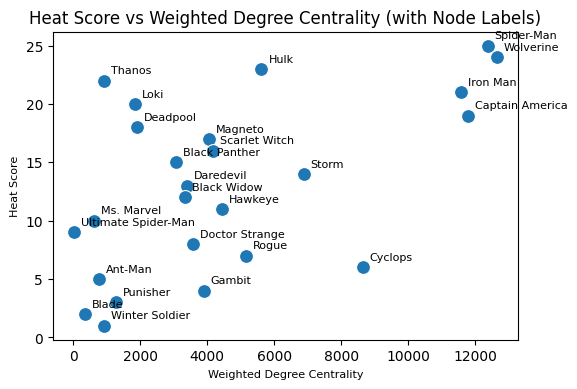

Correlation between Heat_Score and betweenness_centrality: 0.59


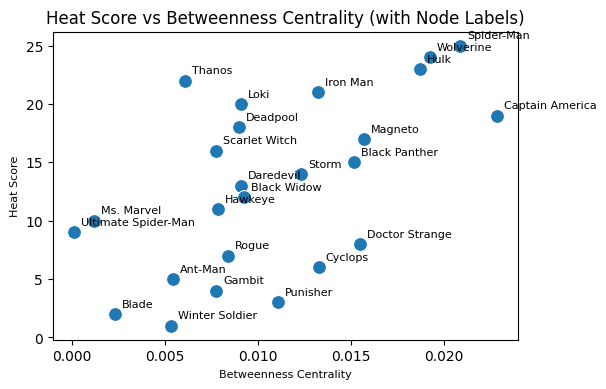

Correlation between Heat_Score and eigenvector_centrality: 0.50


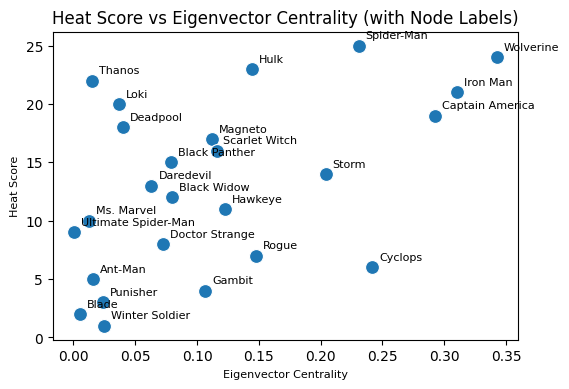

In [126]:
def plot_with_labels(data, x_col, y_col, label_col, title, xlabel, ylabel):
    """
    Plots a scatterplot with labels for each data point and prints the correlation coefficient.

    Args:
    - data: DataFrame containing the data to plot.
    - x_col: Column name for the x-axis.
    - y_col: Column name for the y-axis.
    - label_col: Column name for the labels.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    """
    # Calculate the Pearson correlation coefficient
    corr, _ = pearsonr(data[x_col], data[y_col])
    print(f"Correlation between {y_col} and {x_col}: {corr:.2f}")
    
    # Create scatter plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=data, x=x_col, y=y_col, s=100)
    
    # Add labels to each point
    for i, row in data.iterrows():
        plt.annotate(row[label_col], (row[x_col], row[y_col]),
                     textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8)
    
    # Set title and axis labels
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    
    # Show the plot
    plt.show()

# Transform 'Popularity' into a positive 'Heat Score'
max_rank = merged_df['Popularity'].max()
merged_df['Heat_Score'] = max_rank - merged_df['Popularity'] + 1

# List of centrality measures to plot
centrality_measures = [
    ('weighted_degree_centrality', 'Weighted Degree Centrality'),
    ('betweenness_centrality', 'Betweenness Centrality'),
    ('eigenvector_centrality', 'Eigenvector Centrality')
]

# Loop through each centrality measure and create the plot
for col, col_name in centrality_measures:
    plot_with_labels(
        data=merged_df, 
        x_col=col, 
        y_col='Heat_Score',  # Use the transformed 'Heat_Score' column
        label_col='Node',
        title=f"Heat Score vs {col_name} (with Node Labels)",
        xlabel=col_name,
        ylabel="Heat Score"
    )


# 3. Analysis between Marvel popular character and boxoffice

In [141]:
# API configuration
API_KEY = "95118404"
BASE_URL = "http://www.omdbapi.com/"

movies = [
    # MCU Phase 1
    "Iron Man", "The Incredible Hulk", "Iron Man 2", "Thor",
    "Captain America: The First Avenger", "The Avengers",
    # MCU Phase 2
    "Iron Man 3", "Thor: The Dark World", "Captain America: The Winter Soldier",
    "Guardians of the Galaxy", "Avengers: Age of Ultron", "Ant-Man",
    # MCU Phase 3
    "Captain America: Civil War", "Doctor Strange", "Guardians of the Galaxy Vol. 2",
    "Spider-Man: Homecoming", "Thor: Ragnarok", "Black Panther",
    "Avengers: Infinity War", "Ant-Man and the Wasp", "Captain Marvel",
    "Avengers: Endgame", "Spider-Man: Far From Home",
    # MCU Phase 4
    "Black Widow", "Shang-Chi and the Legend of the Ten Rings", "Eternals",
    "Spider-Man: No Way Home", "Doctor Strange in the Multiverse of Madness",
    "Thor: Love and Thunder", "Black Panther: Wakanda Forever",
    # MCU Phase 5
    "Ant-Man and the Wasp: Quantumania", "Guardians of the Galaxy Vol. 3", "The Marvels",
    # Non-MCU Marvel films
    # X-Men series
    "X-Men", "X2: X-Men United", "X-Men: The Last Stand", "X-Men Origins: Wolverine",
    "X-Men: First Class", "The Wolverine", "X-Men: Days of Future Past",
    "X-Men: Apocalypse", "Logan", "Dark Phoenix", "The New Mutants",
    # Deadpool series
    "Deadpool", "Deadpool 2",
    # Sam Raimi Spider-Man trilogy
    "Spider-Man", "Spider-Man 2", "Spider-Man 3",
    # The Amazing Spider-Man series
    "The Amazing Spider-Man", "The Amazing Spider-Man 2",
    # Fantastic Four series
    "Fantastic Four", "Fantastic Four: Rise of the Silver Surfer", "Fantastic Four (2015)",
    # Venom series
    "Venom", "Venom: Let There Be Carnage",
    # Independent Marvel films
    "Ghost Rider", "Ghost Rider: Spirit of Vengeance", "Daredevil", "Elektra"
]

data = []
for movie in movies:
    params = {"t": movie, "apikey": API_KEY}  # Set API parameters
    response = requests.get(BASE_URL, params=params)  # Send GET request
    
    if response.status_code == 200:  # Check if request was successful
        movie_data = response.json()
        if "Title" in movie_data:  # Check if movie data exists
            data.append({
                "Title": movie_data["Title"],
                "Year": movie_data.get("Year", "N/A"),
                "BoxOffice": movie_data.get("BoxOffice", "N/A"),
                "Director": movie_data.get("Director", "N/A"),
                "Actors": movie_data.get("Actors", "N/A"),
                "IMDB_Rating": movie_data.get("imdbRating", "N/A"),
            })
        else: 
            data.append({"Title": movie, "BoxOffice": "N/A", "Year": "N/A"})
    else: 
        print(f"Failed to fetch data for {movie}")
df = pd.DataFrame(data)

output_file = "Data/marvel_movie_actors.csv"
df.to_csv(output_file, index=False)
print(f"Marvel movie data saved to {output_file}")


Marvel movie data saved to Data/marvel_movie_actors.csv


## 3.1. Relationship between boxoffice and centrality

Unmatched Characters: ['Shuri' 'Yelena Belova' 'Katy' 'Wenwu' 'America Chavez' 'Mighty Thor'
 'Kang the Conqueror' 'Mirage' 'Vanessa' 'The Thing' 'Mephistopheles']
Correlation between weighted_degree_centrality_max and BoxOffice: 0.30


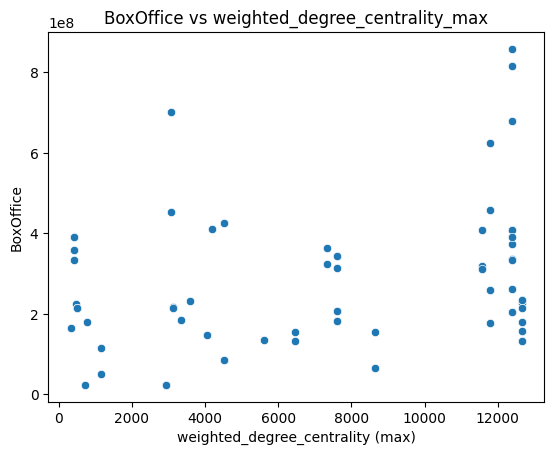

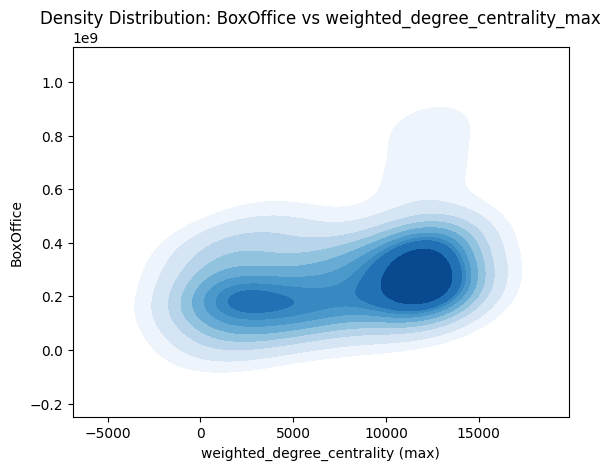

Correlation between betweenness_centrality_max and BoxOffice: 0.39


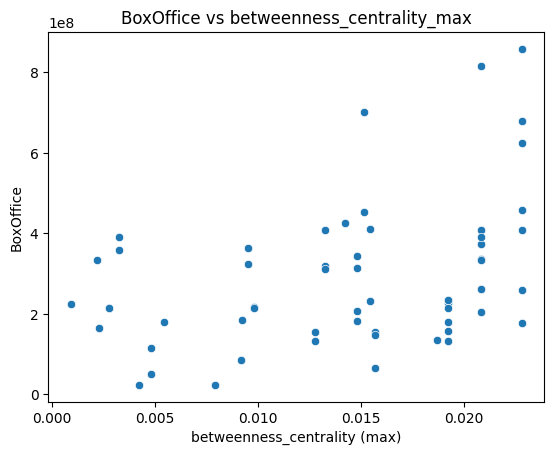

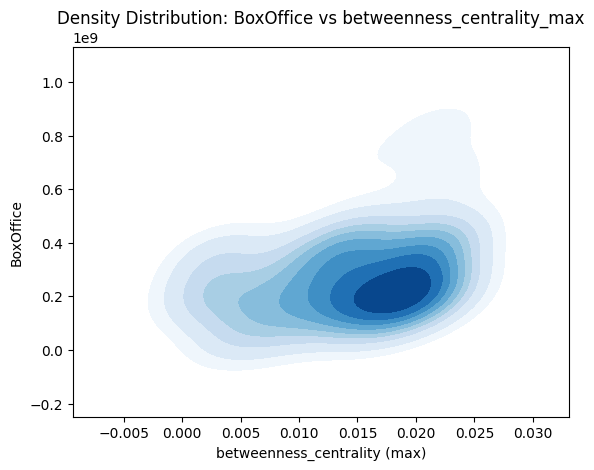

Correlation between eigenvector_centrality_max and BoxOffice: 0.25


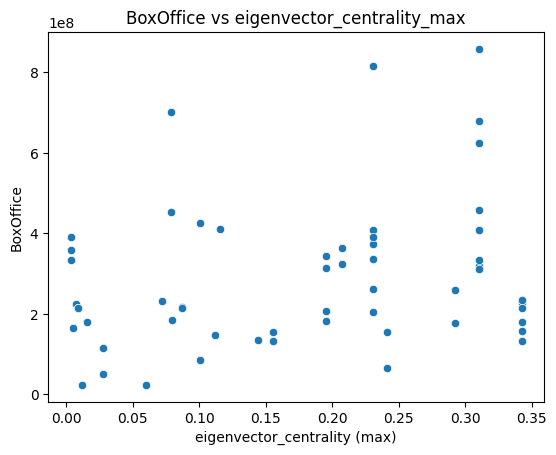

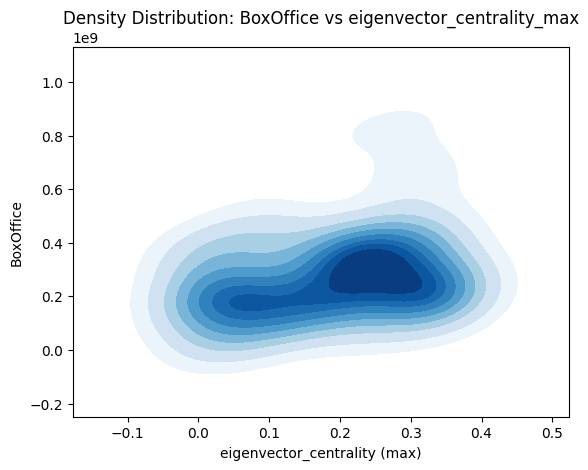

Correlation between pagerank_max and BoxOffice: 0.36


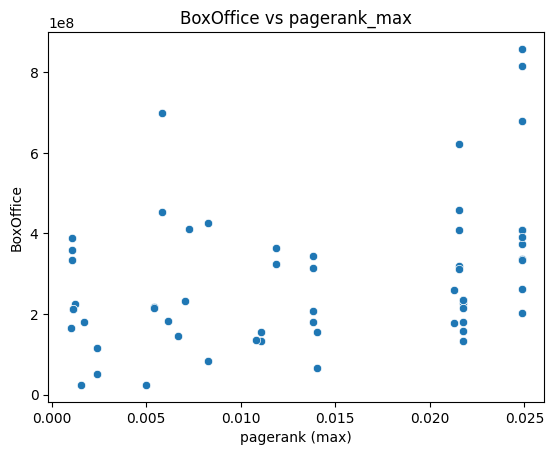

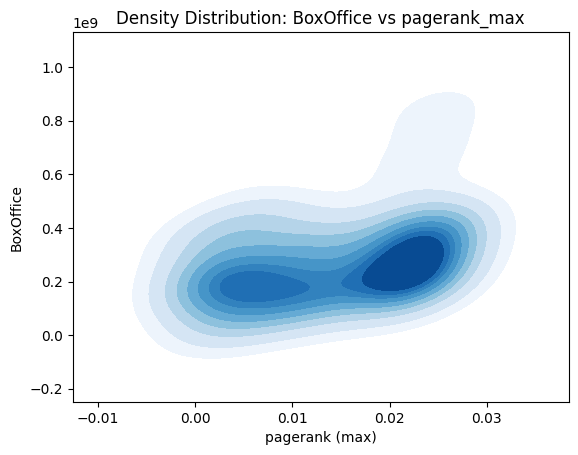

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# ================== Step 1: Read data ==================
centrality_file = "Data/Marvel Character/marvel_character_centrality_metrics.csv"
movie_characters_file = "Data/marvel_movie_characters.csv"

# Load data
centrality_df = pd.read_csv(centrality_file)  # Contains character and centrality metrics
movie_df = pd.read_csv(movie_characters_file)  # Contains Title, Year, BoxOffice, Actors, etc.

# ================== Step 2: Clean data (remove extra spaces) ==================
movie_df['Actors'] = movie_df['Actors'].str.strip()                # Remove spaces in Actors column
centrality_df['character'] = centrality_df['character'].str.strip() # Remove spaces in character column

# ================== Step 3: Convert Actors to list, then explode ==================
movie_df['Actors'] = movie_df['Actors'].apply(
    lambda x: x.split(',') if isinstance(x, str) else [x]
)

movie_df = movie_df.explode('Actors')

movie_df['Actors'] = movie_df['Actors'].str.strip()

# ================== Step 4: Merge centrality metrics into movie data ==================
movie_df = movie_df.merge(centrality_df, left_on="Actors", right_on="character", how="left")

# ================== Step 5: Check unmatched characters ==================
unmatched_characters = movie_df[movie_df['character'].isna()]['Actors'].unique()
print(f"Unmatched Characters: {unmatched_characters}")

# ================== Step 6: Replace NaN in centrality metrics with 0 ==================
centrality_metrics = ['weighted_degree_centrality', 'betweenness_centrality',
                      'eigenvector_centrality', 'pagerank']

for metric in centrality_metrics:
    movie_df[metric] = movie_df[metric].fillna(0)

# ================== Step 7: Calculate max centrality for each movie ==================
aggregated_data = movie_df.groupby("Title")[centrality_metrics].max().reset_index()

# Rename columns to include "_max"
aggregated_data.rename(columns={metric: f"{metric}_max" for metric in centrality_metrics}, inplace=True)

# ================== Step 8: Merge with BoxOffice data ==================
boxoffice_data = movie_df[['Title', 'BoxOffice']].drop_duplicates()

boxoffice_data['BoxOffice'] = boxoffice_data['BoxOffice'].replace('[\$,]', '', regex=True).astype(float)

aggregated_data = aggregated_data.merge(boxoffice_data, on="Title", how="inner")

# ================== Step 9: Clean final data ==================
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)
aggregated_data.dropna(subset=['BoxOffice'], inplace=True)

# ================== Step 10: Correlation analysis with density plot ==================
for metric in centrality_metrics:
    max_col = f"{metric}_max"
    
    # Correlation analysis
    corr_max, _ = pearsonr(aggregated_data[max_col], aggregated_data['BoxOffice'])
    print(f"Correlation between {max_col} and BoxOffice: {corr_max:.2f}")
    
    # Scatter plot
    sns.scatterplot(data=aggregated_data, x=max_col, y='BoxOffice')
    plt.title(f"BoxOffice vs {max_col}")
    plt.xlabel(metric + " (max)")
    plt.ylabel("BoxOffice")
    plt.show()
    
    # Density plot (KDE)
    sns.kdeplot(data=aggregated_data, x=max_col, y='BoxOffice', fill=True, cmap="Blues", thresh=0.1)
    plt.title(f"Density Distribution: BoxOffice vs {max_col}")
    plt.xlabel(metric + " (max)")
    plt.ylabel("BoxOffice")
    plt.show()



## 3.2. Relationship between community number and Box office

Correlation between unique_community_count and BoxOffice: 0.33


/var/folders/gf/3w65ksvn4dggz77k_70wnj8c0000gn/T/ipykernel_10874/2439743935.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_stats = movies_df.groupby('Title').apply(calculate_community_stats).reset_index()


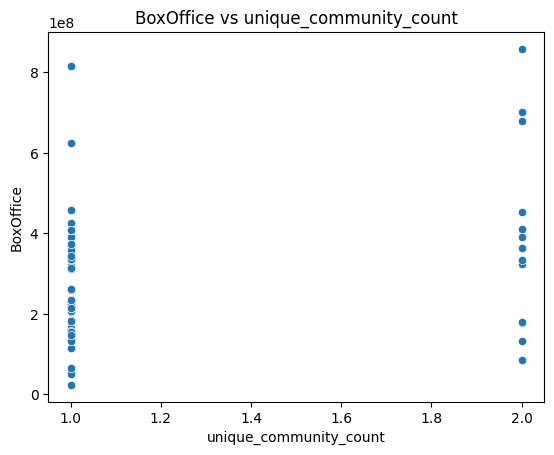

Correlation between main_community_ratio and BoxOffice: -0.25


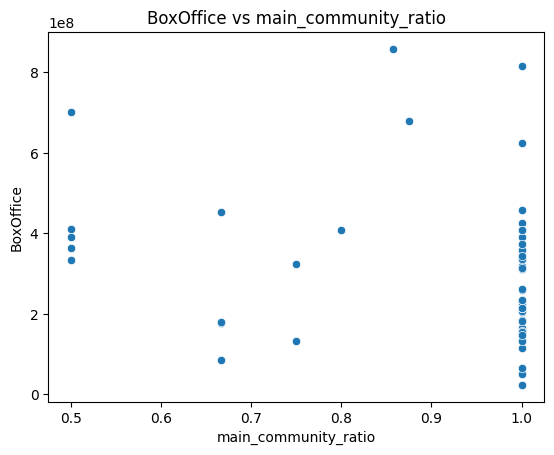

Correlation between community_entropy and BoxOffice: 0.27


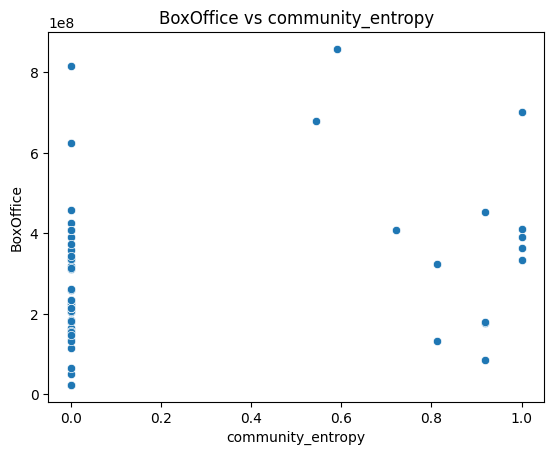

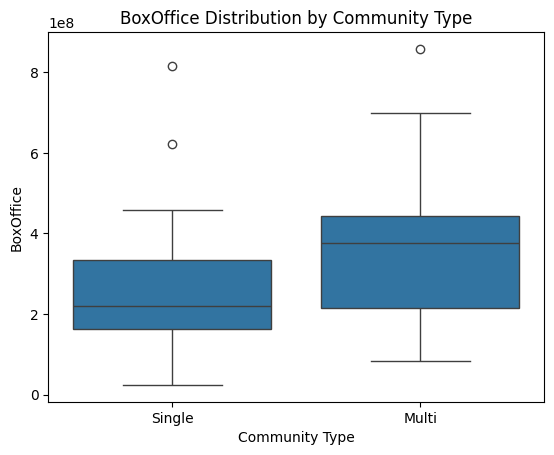

T-test: t-statistic = -2.13, p-value = 4.85e-02


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# ================== Step 1: Load data ==================
nodes_file = "Data/Marvel Character/Gephi Data/marvel_character_nodes_table.csv"
edges_file = "Data/Marvel Character/Gephi Data/marvel_character_edges_table.csv"
movies_file = "Data/marvel_movie_characters.csv"

# Load files
nodes_df = pd.read_csv(nodes_file)  # Contains ID, Label, Community
edges_df = pd.read_csv(edges_file)  # Contains Source, Target, Weight
movies_df = pd.read_csv(movies_file)  # Contains Title, Actors, BoxOffice

# ================== Step 2: Prepare nodes and movie data ==================
# Clean Actors column
movies_df['Actors'] = movies_df['Actors'].str.strip()
movies_df['Actors'] = movies_df['Actors'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
movies_df = movies_df.explode('Actors')
movies_df['Actors'] = movies_df['Actors'].str.strip()

# Merge movie data with nodes to get community information
movies_df = movies_df.merge(nodes_df, left_on='Actors', right_on='Label', how='left')

# ================== Step 3: Calculate community statistics ==================
def calculate_community_stats(group):
    community_counts = group['Community'].value_counts(normalize=False)
    total_characters = community_counts.sum()
    proportions = community_counts / total_characters

    # Unique community count
    unique_community_count = len(community_counts)

    # Main community ratio
    main_community_ratio = proportions.max()

    # Community entropy
    community_entropy = -np.sum(proportions * np.log2(proportions)) if unique_community_count > 1 else 0

    return pd.Series({
        'unique_community_count': unique_community_count,
        'main_community_ratio': main_community_ratio,
        'community_entropy': community_entropy
    })

community_stats = movies_df.groupby('Title').apply(calculate_community_stats).reset_index()

# ================== Step 4: Merge with BoxOffice data ==================
movies_df['BoxOffice'] = movies_df['BoxOffice'].replace('[\$,]', '', regex=True).astype(float)
boxoffice_data = movies_df[['Title', 'BoxOffice']].drop_duplicates()
community_stats = community_stats.merge(boxoffice_data, on='Title', how='inner')

# Remove rows with NaN values in BoxOffice or community metrics
community_stats.dropna(subset=['BoxOffice', 'unique_community_count', 'main_community_ratio', 'community_entropy'], inplace=True)

# Save the combined data
community_stats.to_csv("Data/community_boxoffice_analysis.csv", index=False)

# ================== Step 5: Correlation analysis ==================
correlation_metrics = ['unique_community_count', 'main_community_ratio', 'community_entropy']
for metric in correlation_metrics:
    corr, _ = pearsonr(community_stats[metric], community_stats['BoxOffice'])
    print(f"Correlation between {metric} and BoxOffice: {corr:.2f}")

    sns.scatterplot(data=community_stats, x=metric, y='BoxOffice')
    plt.title(f"BoxOffice vs {metric}")
    plt.xlabel(metric)
    plt.ylabel("BoxOffice")
    plt.show()

# ================== Step 6: Single vs Multi-community analysis ==================
community_stats['community_type'] = community_stats['unique_community_count'].apply(lambda x: 'Single' if x == 1 else 'Multi')

# Boxplot
sns.boxplot(data=community_stats, x='community_type', y='BoxOffice')
plt.title("BoxOffice Distribution by Community Type")
plt.xlabel("Community Type")
plt.ylabel("BoxOffice")
plt.show()

# T-test
single_community = community_stats[community_stats['community_type'] == 'Single']['BoxOffice']
multi_community = community_stats[community_stats['community_type'] == 'Multi']['BoxOffice']

t_stat, p_value = ttest_ind(single_community, multi_community, equal_var=False)
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.2e}")




## 3.3. Relationship between collabaration and Box office

Correlation between total_collaborations and BoxOffice: 0.52


/var/folders/gf/3w65ksvn4dggz77k_70wnj8c0000gn/T/ipykernel_10874/3444935293.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  collaboration_stats = movies_df.groupby('Title').apply(calculate_collaboration_metrics).reset_index()


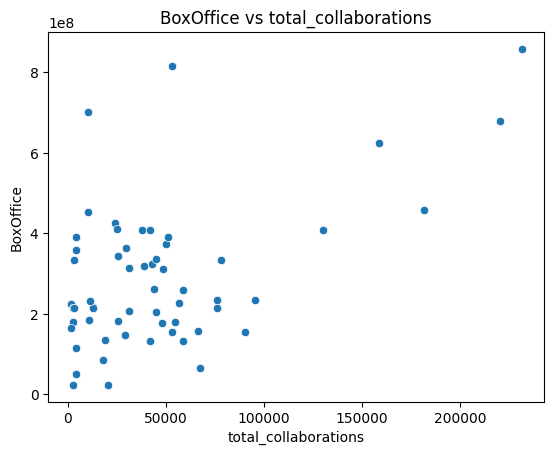

Correlation between average_collaborations and BoxOffice: 0.16


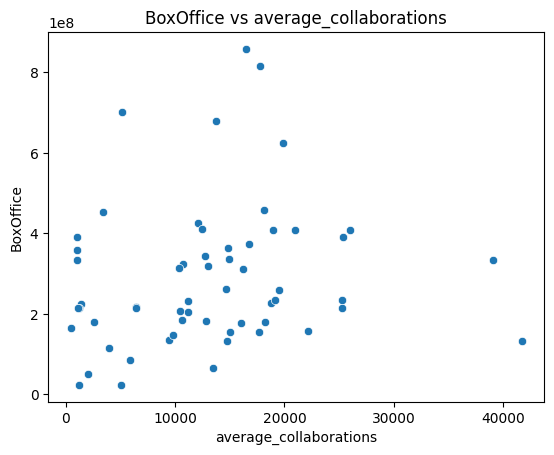

In [198]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# ================== Step 1: Load data ==================
collaboration_matrix_file = "Data/Marvel Character/marvel_character_collaboration.csv"
movies_file = "Data/marvel_movie_characters.csv"

# Load collaboration matrix
collaboration_matrix = pd.read_csv(collaboration_matrix_file, index_col=0)  # First column is the row index (character names)

# Load movies file
movies_df = pd.read_csv(movies_file)  # Contains Title, Actors, BoxOffice

# ================== Step 2: Calculate Total Collaborations ==================
# Calculate the total collaborations for each character
collaboration_totals = collaboration_matrix.sum(axis=1)  # Row-wise sum
collaboration_totals = collaboration_totals.reset_index()
collaboration_totals.columns = ['Character', 'Total Collaborations']

# ================== Step 3: Prepare movie and collaboration data ==================
# Clean Actors column in movies_df
movies_df['Actors'] = movies_df['Actors'].str.strip()
movies_df['Actors'] = movies_df['Actors'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
movies_df = movies_df.explode('Actors')
movies_df['Actors'] = movies_df['Actors'].str.strip()

# Merge movies with collaboration totals
movies_df = movies_df.merge(collaboration_totals, left_on='Actors', right_on='Character', how='left')

# ================== Step 4: Calculate collaboration statistics for movies ==================
def calculate_collaboration_metrics(group):
    total_collaborations = group['Total Collaborations'].sum()
    average_collaborations = group['Total Collaborations'].mean() if len(group) > 0 else 0
    return pd.Series({
        'total_collaborations': total_collaborations,
        'average_collaborations': average_collaborations
    })

collaboration_stats = movies_df.groupby('Title').apply(calculate_collaboration_metrics).reset_index()

# ================== Step 5: Merge with BoxOffice data ==================
movies_df['BoxOffice'] = movies_df['BoxOffice'].replace('[\$,]', '', regex=True).astype(float)
boxoffice_data = movies_df[['Title', 'BoxOffice']].drop_duplicates()
collaboration_stats = collaboration_stats.merge(boxoffice_data, on='Title', how='inner')

# Remove rows with NaN values in BoxOffice or collaboration metrics
collaboration_stats.dropna(subset=['BoxOffice', 'total_collaborations', 'average_collaborations'], inplace=True)

# Save the combined data
collaboration_stats.to_csv("Data/collaboration_boxoffice_analysis.csv", index=False)

# ================== Step 6: Correlation analysis ==================
correlation_metrics = ['total_collaborations', 'average_collaborations']
for metric in correlation_metrics:
    corr, _ = pearsonr(collaboration_stats[metric], collaboration_stats['BoxOffice'])
    print(f"Correlation between {metric} and BoxOffice: {corr:.2f}")

    sns.scatterplot(data=collaboration_stats, x=metric, y='BoxOffice')
    plt.title(f"BoxOffice vs {metric}")
    plt.xlabel(metric)
    plt.ylabel("BoxOffice")
    plt.show()

# ================== Step 7: Save final data ==================
collaboration_stats_sorted = collaboration_stats.sort_values(by='BoxOffice', ascending=False)
collaboration_stats_sorted.to_csv("Data/collaboration_stats_sorted.csv", index=False)



In [ ]:
# 方向 1: 中心性与票房的关系 aggregated_data.rename(columns={'Title_': 'Title'}, inplace=True)
# 目标
# 探索角色的网络中心性（如度中心性、介数中心性等）是否对电影票房有显著影响。

# 实现步骤
# 计算每个角色的中心性:

# 使用 NetworkX 的方法（degree_centrality, betweenness_centrality, eigenvector_centrality）。
# 将中心性数据与电影角色表关联，每部电影中保留主要角色的中心性。
# 汇总电影的中心性数据:

# 计算每部电影中主要角色的 平均中心性 和 最大中心性，作为中心性指标。
# 合并票房数据:

# 使用电影名称将票房数据和中心性数据合并，生成一个完整数据框。
# 相关性分析与回归分析:

# 相关性: 计算中心性指标与票房的皮尔逊相关系数。
# 回归分析: 构建线性回归模型，将票房作为因变量，中心性作为自变量，评估影响。
# 关键问题
# 是否具有高中心性的角色（如 Iron Man）会显著提升票房？
# 平均中心性和最大中心性哪个对票房影响更大？
# 方向 2: 社区结构与票房的关系
# 目标
# 研究电影中角色网络的社区结构与票房之间的关系。

# 实现步骤
# 社区划分:

# 使用 Louvain 算法对完整角色网络进行社区划分，生成每个节点的社区标记。
# 统计每部电影的社区数据:

# 统计每部电影中涉及的 社区数量 和 主要社区的比例。
# 计算每部电影角色的社区分布多样性（如熵值）。
# 合并票房数据:

# 通过电影名称合并社区数据和票房数据。
# 分析社区与票房的关系:

# 多样性分析: 检查社区数量或熵值是否与票房显著相关。
# 交互分析: 比较单社区电影（如《钢铁侠》）和多社区电影（如《复仇者联盟》）的票房差异。
# 关键问题
# 是否多社区合作（如复仇者联盟和银河护卫队联合）更容易带来高票房？
# 主要社区占比是否会削弱多样性对票房的提升作用？
# 方向 3: 合作密度与票房
# 目标
# 探索电影中角色间合作关系的强度（如边权重或合作密度）是否对票房有显著影响。

# 实现步骤
# 计算合作密度:

# 统计每部电影中角色网络的 总边权重、平均边权重 和 密度（节点间连接的紧密程度）。
# 汇总电影的合作数据:

# 对每部电影提取合作指标（如总边权重、平均权重），生成合作密度数据表。
# 合并票房数据:

# 将合作密度数据与票房数据合并。
# 相关性分析与回归分析:

# 检查合作密度与票房的相关性。
# 构建回归模型，验证合作密度对票房的影响显著性。
# 关键问题
# 是否更频繁的角色合作（高边权重）更容易推动票房增长？
# 合作密度是否在特定类型电影（如群像电影）中表现更显著？
# 可视化建议
# 散点图:

# 分别绘制中心性、社区数量、合作密度与票房的散点图，观察直观关系。
# 热图:

# 可视化多变量（如平均中心性和社区数量）与票房的交互关系。
# 箱线图:

# 比较单社区电影和多社区电影的票房分布差异。
